# Deep Learning -Week 6: Final Project - Categorizing Solar Eclipse Phases

In this project, we will use CNN to categorize pictures taken from the different phases of a solar eclipse.


The Kaggle page that contains the details of the compentions can be found inthis URL:

https://www.kaggle.com/competitions/eclipse-megamovie/overview


This notebook can be found in Github :

https://github.com/laguila11/eclipse

## Step 1. Brief description of the problem and data

A total solar eclipse happens when the Moon passes between the Sun and Earth, casting a shadow on Earth that fully blocks the Sun’s light in some areas. This only happens occasionally, because the Moon doesn't orbit in the exact same plane as the Sun and Earth do. The time when they are aligned is known as eclipse season, which can happen twice a year.

This Kaggle competition mission is to create the most accurate sorting machine that categorizes a solar eclipse photograph into a specific solar eclipse phase.

For this project, we will have access to a dataset of 495 pictures that were hand classified and 140 test pictures. In the train file metadata along with the picture ID we have the label category that indicates what kind of eclipse phase the picure corresponds.  

The following data sets are provided in the Kaggle page to train and test the model:
 
- train - a folder containing the training images
- test - a folder containing the test images
- label_num_to_phase_map.json - The mapping between each phase code and the real phase name.
- sample_submission.csv - a sample submission file in the correct format
- train.csv - maps the training Image to the appropriate phase Id.

### Loading libraries and datasets

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

import json
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the data
path =''
train_df = pd.read_csv(path + 'train.csv')

# Load the JSON file
with open(path+'label_num_to_phase_map.json', 'r') as f:
    label_map = json.load(f)

phase_map = label_map

# Reverse the phase_map to map from integers (label) to phase names
reversed_phase_map = {v: k for k, v in phase_map.items()}

# Load the train.csv
train_df = pd.read_csv(path + 'train.csv')

# Map the integer labels in the train.csv to the corresponding phase names
train_df['phase_name'] = train_df['label'].map(reversed_phase_map)

# dataset information
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    495 non-null    object
 1   label       495 non-null    int64 
 2   phase_name  495 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.7+ KB
None


## Step 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section we will check the dataset, explore any need to clean the data and perform some basic analysis on their contents.

Also we will visualize the different pictures in the training dataset and their categorties in order to get some intution of the classification challenges and some basic statistics.

In [3]:
# Display first few rows of the dataset
print("First few rows of the training data:")
print(train_df.head())

# Check for missing values
print("\nChecking for missing values:")
print(train_df.isnull().sum())

# Basic statistics on the phase distribution
print("\nPhase distribution in the dataset:")
phase_counts = train_df['phase_name'].value_counts()
print(phase_counts)

# Ensure that the 'label' column values are treated as strings for categorical mode
train_df['label'] = train_df['label'].astype(str)

First few rows of the training data:
                                            image_id  label         phase_name
0  0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0  TotalSolarEclipse
1  ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0  TotalSolarEclipse
2  eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0  TotalSolarEclipse
3  fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0  TotalSolarEclipse
4  00387215fa1ed9032f9cf110dd19a597c020616ce60597...      0  TotalSolarEclipse

Checking for missing values:
image_id      0
label         0
phase_name    0
dtype: int64

Phase distribution in the dataset:
phase_name
TotalSolarEclipse                        186
Darks                                     65
56to95percentPartialEclipse               57
0to25percentPartialEclipse                52
DiamondRing_BaileysBeads_SolarEclipse     43
26to55percentPartialEclipse               38
NotASolarEclipse                          36
Flats                               

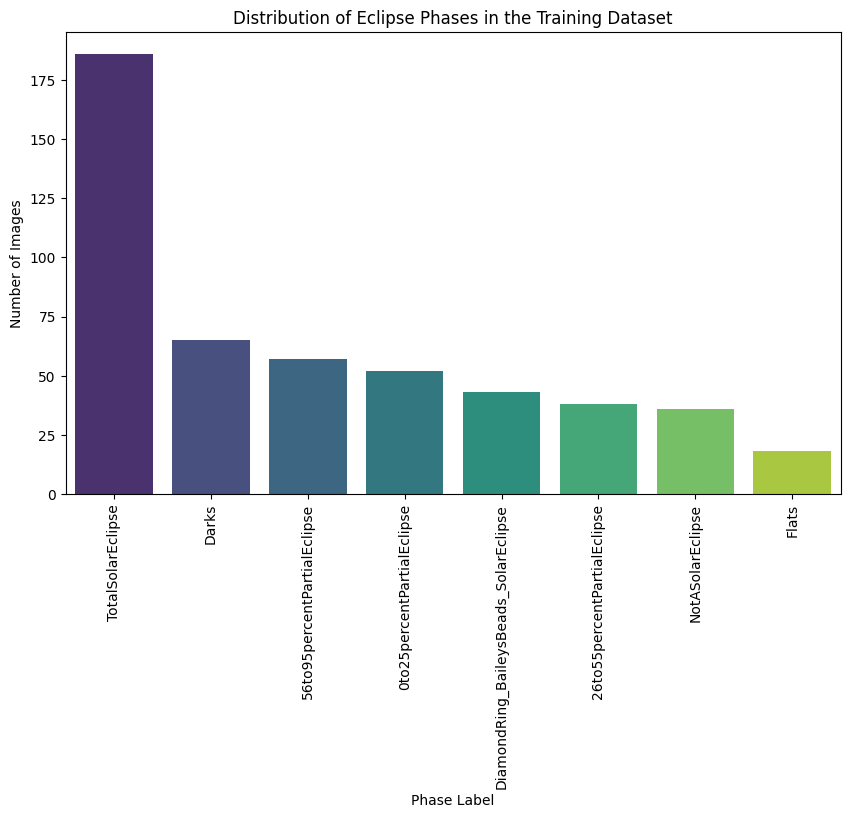

In [4]:
# Plot the distribution of eclipse phases (labels)
plt.figure(figsize=(10, 6))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette="viridis")
plt.title('Distribution of Eclipse Phases in the Training Dataset')
plt.xlabel('Phase Label')
plt.ylabel('Number of Images')
# Rotate the x labels by 90 degrees to make them vertical
plt.xticks(rotation=90)
plt.show()

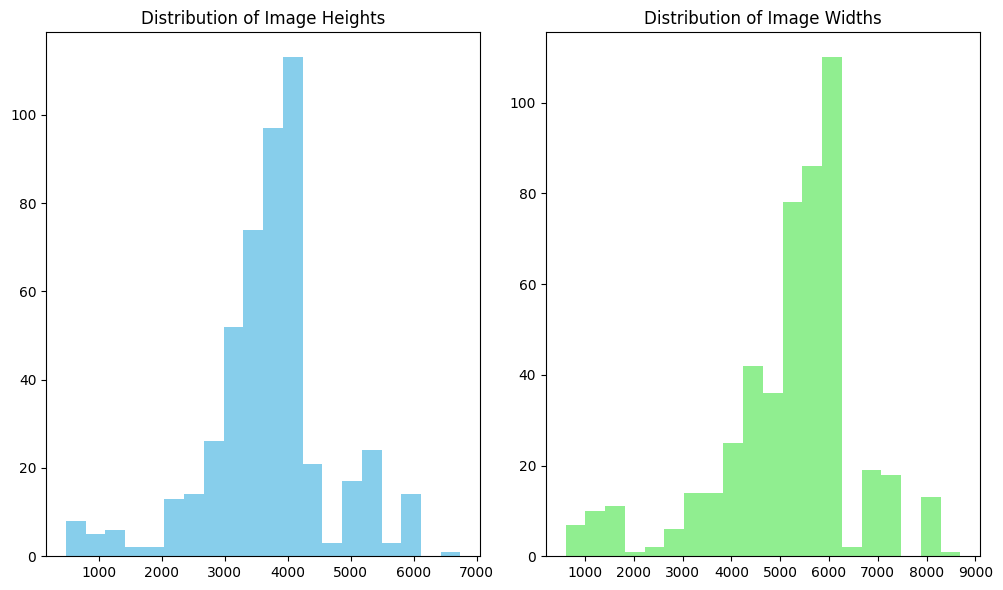

In [5]:
# Path to your train image directory
image_dir = path + 'train'  # Replace with the actual path

# Histogram of image widths and heights (if they vary in size)
image_shapes = [plt.imread(os.path.join(image_dir, img_file)).shape for img_file in os.listdir(image_dir)[:500]]

image_heights = [shape[0] for shape in image_shapes]
image_widths = [shape[1] for shape in image_shapes]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(image_heights, bins=20, color='skyblue')
plt.title('Distribution of Image Heights')

plt.subplot(1, 2, 2)
plt.hist(image_widths, bins=20, color='lightgreen')
plt.title('Distribution of Image Widths')
plt.tight_layout()
plt.show()

### Observations

There is no need for data cleaning. All labels have proper values.

**Size heterogeneity** there is huge variation in width and high of the images in the dataset, which will pose challenges when trying to train the model.

**TotalSolarEclipse** is dominant: The category "TotalSolarEclipse" has significantly more images than any other phase, with nearly 180 images. This indicates a potential imbalance in the dataset, as this phase is far more frequent than others.

The **Flats** phase, has much fewer images (around 25).

**Concern: Imbalanced Dataset**

The plot highlights a significant class imbalance. The "TotalSolarEclipse" phase is disproportionately represented compared to the other phases, which could lead to biases during training where the model may favor this dominant class.This imbalance might affect the model's ability to generalize well on underrepresented phases.

### Visualization of 3 random images images of each category

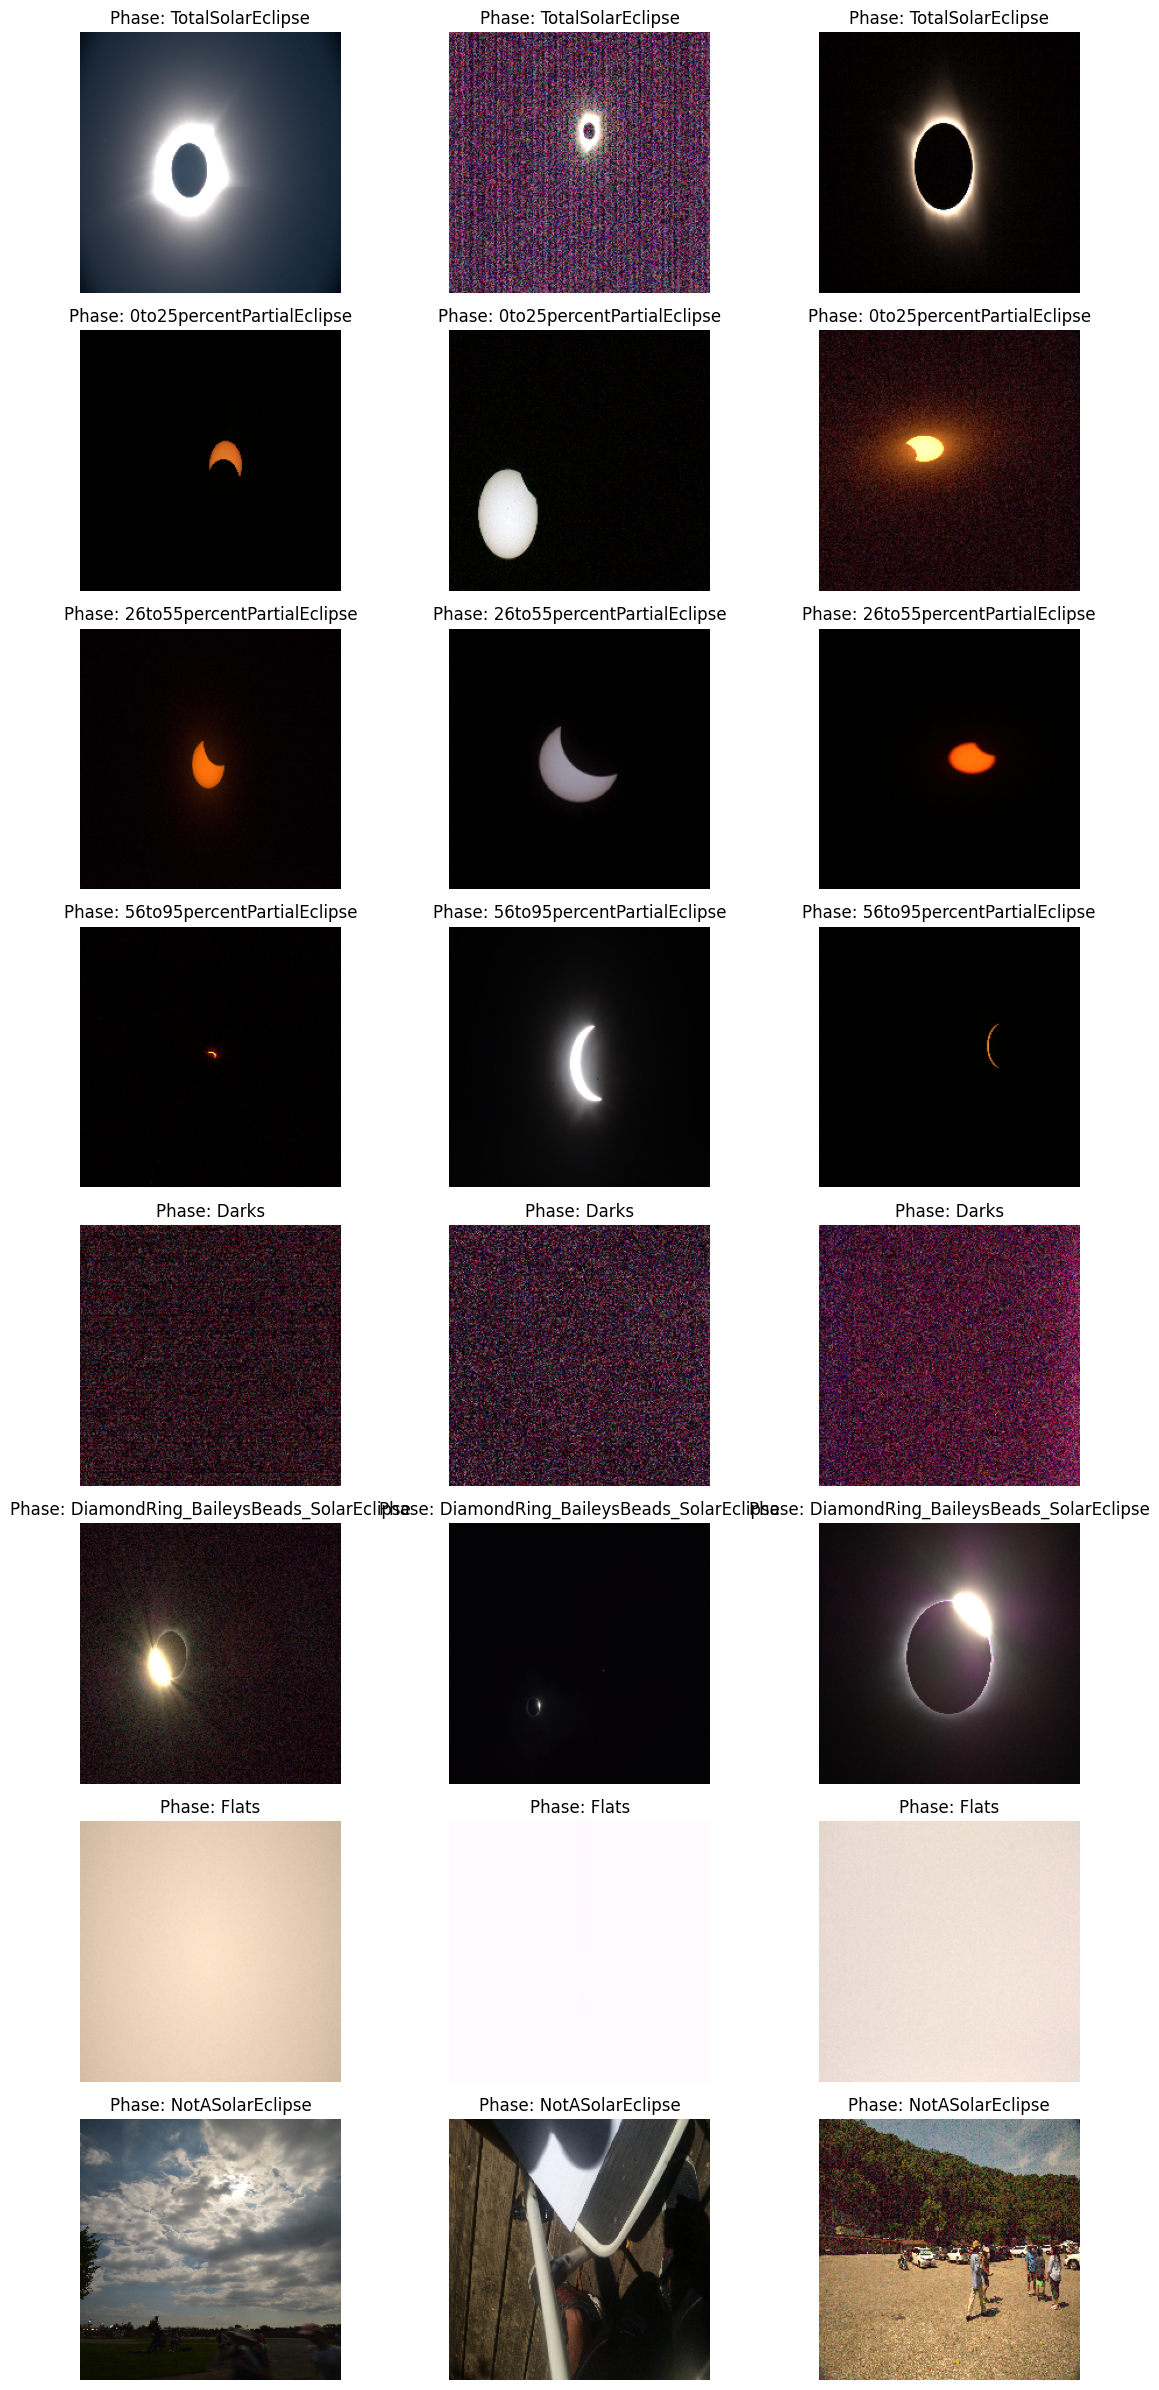

In [6]:

# Get unique categories (labels)
unique_categories = train_df['label'].unique()

# Set up the figure (adjusting figure size based on number of images to display)
plt.figure(figsize=(12, len(unique_categories) * 3))

# Loop through each category and show 3 random examples
for i, category in enumerate(unique_categories):
    # Get three random examples from the category
    random_examples = train_df[train_df['label'] == category].sample(3)
    
    # Loop through the 3 random examples and display each
    for j, (_, example) in enumerate(random_examples.iterrows()):
        # Get the image path
        img_path = os.path.join(image_dir, example['image_id'])
        
        # Load the image
        img = load_img(img_path, target_size=(224, 224))  # Resize to (224, 224) or any size you prefer
        img_array = img_to_array(img) / 255.0  # Normalize the image

        # Plot the image
        plt.subplot(len(unique_categories), 3, i * 3 + j + 1)  # 3 images per row for each category
        plt.imshow(img_array)
        plt.axis('off')
        
        # Display the phase name (already present in the dataset)
        phase_name = example['phase_name']  # Get the phase name
        plt.title(f"Phase: {phase_name}")

# Show the plot
plt.tight_layout()
plt.show()

### Observations

Looking at some of these categories, we anticipate that there will certain labels that will be challenging to properly produce. In particular, the **NotASolarEclipse** is basically anything from pictures taken by mistake, planet pictures, or even people. 

## Step 3.  Model Architecture

Here we will describe the different model architectures and reasoning for why the specific architecture might be suitable for this problem. 

We started with a simple CNN with a few layers but the model could simply not be trained to achieve a reasonable level of accuracy > 50%.

Since the amount of train data is quite low (only 495 pictures) we decided to add a pre-trained CNN layer that will help the model to learn. We tried both VGG16 and MobileNetV2 and finally opted for using MobileNetV2 as it was trained faster.

In order to make the model keep the learnings, we added a series of 2D Convolutional and Dense layers to hit a balance between training speed.

Since the image resolution and size in the train datasets are very heterogenous, we upscale the train images slightly to capture details that might not be significant enough (if too small) or maybe not centered in the image.

Also since the data was scarse, another measure that we took was to increase the images size to train and validate the model to 224x224 (from the standard 128x128). Despite the greater memory consumption, this helped accelerate the training process.

Another issue that we tried to address was the imbalance in the training dataset as per the different labels. We added weight to the model but it only made it worse; still I don't have a good explanation.

Finally, we tried several combination of hyperparameters to help the model converge in the training process, while keeping the accuracy of the test acceptable (not to overfit). 

At the ended we chose a combination that balances the stickness of the different layers (with standard dropout values of 0.4), a slightly lower than standard learning rate of 0.0005, 7 epochs and batch size of 16. 

The training process is hitting some hicups with the data as every other epochs runs almost instantly and generates some volatile performance. That is very visable in the visualization of the training peformance plot. To date, and after attemping all way to resolve it, it is still pending.

At the end of the section, we will coment on the execution and prepare for the results and conclusions.

In [7]:
# Define image size and batch size
IMG_SIZE = (224, 224)  # Resize to a fixed size for heterogeneous images
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3
)

# Validation set does not need data augmentation, just rescale
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2      # Same split for validation
)

# Load training and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory= path + 'train/',                # Path to the train images folder
    x_col='image_id',                  # Column in train.csv with image filenames
    y_col='label',                     # Using numeric labels
    target_size=IMG_SIZE,              # Resize all images to a fixed size
    batch_size=BATCH_SIZE,
    class_mode='categorical',          # Multi-class classification
    subset='training',                 # Training subset
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory= path +'train/',                # Path to the train images folder
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'                # Validation subset
)

Found 396 validated image filenames belonging to 8 classes.
Found 99 validated image filenames belonging to 8 classes.


In [8]:
# Compute the correct number of steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Load MobileNetV2 with local weights
mobilenet_base = MobileNetV2(weights='mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', 
                             include_top=False, 
                             input_shape=(IMG_SIZE[0], IMG_SIZE[0], 3))

# Freeze the layers of MobileNetV2
for layer in mobilenet_base.layers:
    layer.trainable = False

# Create the model
model = Sequential()


# Add the MobileNetV2 base
model.add(mobilenet_base)

# Add custom convolutional layers on top of VGG16 base
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Flatten the convolutional output
model.add(Flatten())

# Add fully connected layers (Dense layers)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))


# Output layer with softmax for multi-class classification
model.add(Dense(len(phase_map), activation='softmax'))

# Set custom learning rate
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)


# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=7
    
    #steps_per_epoch=steps_per_epoch,
    #validation_steps=validation_steps
)

Epoch 1/7


2024-10-12 19:51:39.406672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-12 19:51:43.066639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3842 - loss: 1.7909 - val_accuracy: 0.1818 - val_loss: 2.2743
Epoch 2/7


2024-10-12 19:52:46.195068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:57 15s/step - accuracy: 0.6875 - loss: 1.0284

2024-10-12 19:52:49.375596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6455 - loss: 0.9839 - val_accuracy: 0.5758 - val_loss: 0.8831
Epoch 3/7


2024-10-12 19:53:46.506306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:53 15s/step - accuracy: 0.6250 - loss: 0.9390

2024-10-12 19:53:50.163762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7145 - loss: 0.7655 - val_accuracy: 0.7071 - val_loss: 0.7690
Epoch 4/7


2024-10-12 19:54:47.752780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:58 15s/step - accuracy: 1.0000 - loss: 0.2592

2024-10-12 19:54:51.867567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8106 - loss: 0.5772 - val_accuracy: 0.7980 - val_loss: 0.4081
Epoch 5/7


2024-10-12 19:55:50.760034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 6:16 16s/step - accuracy: 0.8125 - loss: 0.7432

2024-10-12 19:55:54.784908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8513 - loss: 0.5833 - val_accuracy: 0.7374 - val_loss: 0.6558
Epoch 6/7


2024-10-12 19:56:51.667981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 6:25 16s/step - accuracy: 0.8750 - loss: 0.4638

2024-10-12 19:56:57.201176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8489 - loss: 0.4992 - val_accuracy: 0.9596 - val_loss: 0.2098
Epoch 7/7


2024-10-12 19:57:53.656147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


 1/25 ━━━━━━━━━━━━━━━━━━━━ 6:24 16s/step - accuracy: 0.8125 - loss: 0.5068

2024-10-12 19:57:59.286629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8252 - loss: 0.5416 - val_accuracy: 0.8182 - val_loss: 0.5489


In [9]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,365,530 (31.91 MB)

 Trainable params: 2,035,592 (7.77 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

 Optimizer params: 4,071,186 (15.53 MB)

None


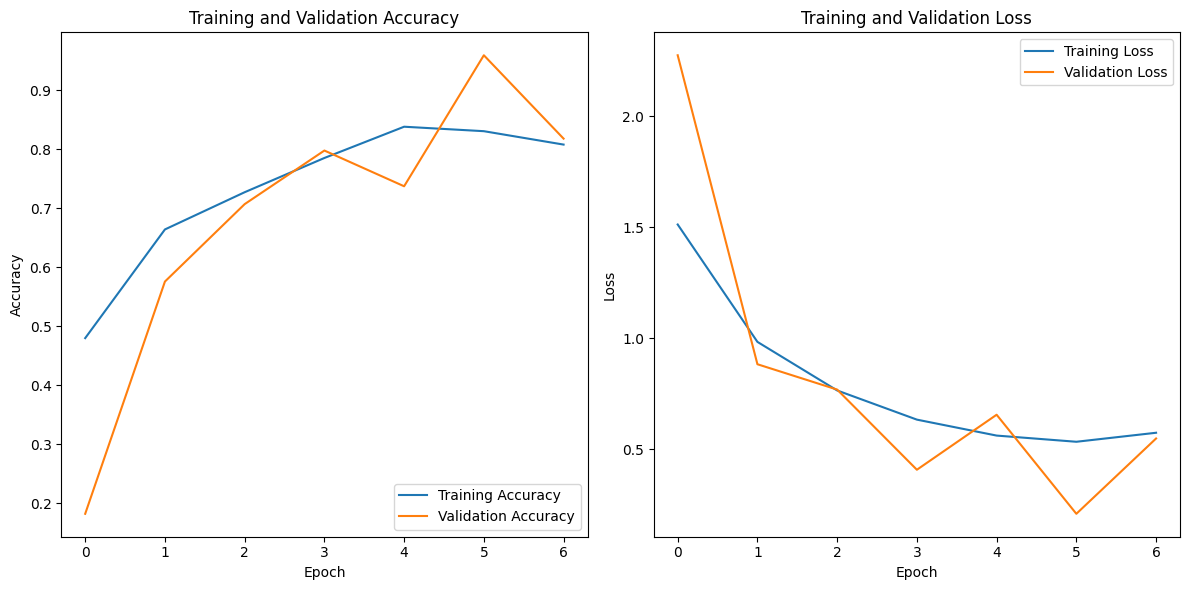

In [10]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()


### Observations


- The training accuracy improves steadily over time and starts to level off after epoch 4, reaching a plateau around 0.85–0.9. This is a good sign indicating the model is learning the patterns in the training data.

- The validation accuracy shows large fluctuations between epochs, with a significant jump early in the training phase (around epoch 1-2) but then experiences peaks and valleys.

- The training loss decreases steadily and continuously throughout the epochs, showing a smooth decline. The final training loss is very low, indicating the model has learned the training data well.

- The validation loss initially decreases sharply but starts fluctuating after epoch 3-4, similar to validation accuracy. These fluctuations could indicate overfitting

- Potential issues: 1) Overfitting: The significant fluctuation in validation accuracy and validation loss suggests that the model is overfitting to the training data. 2) Validation Instability: The large variability in validation performance may also indicate that the model is sensitive to the validation data, which could be due to an imbalanced dataset or inadequate validation data size.



## Step 4. Results and Analysis

We will first visualize the results of the classification of the test using the model we just trained.
As a sample, we will display 3 random test images and its classifications for each of the 8 categories.


In [11]:
# Directory where the test images are stored
test_dir = path + 'test/'

# Get the list of image filenames from the test directory
test_image_filenames = os.listdir(test_dir)


# Create a DataFrame using the filenames for prediction
test_df = pd.DataFrame({
    'image_id': test_image_filenames
})


In [12]:
# Test data generator (no labels since you're making predictions)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator, pointing to the /test directory
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,        # Correct path to the test images folder
    x_col='image_id',          # Column with image filenames
    target_size=IMG_SIZE,      # Same target size as training
    batch_size=BATCH_SIZE,
    class_mode=None,           # No labels for test data
    shuffle=False              # Don't shuffle test data
)

Found 140 validated image filenames.


In [13]:
# Number of images to display per category
images_per_category = 3

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert predictions to numeric class labels
predicted_classes = np.argmax(predictions, axis=1)

# Map numeric class labels back to phase names using the phase map
predicted_phases = [list(phase_map.keys())[i] for i in predicted_classes]

# Get unique predicted phases (categories)
unique_categories = np.unique(predicted_phases)



9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


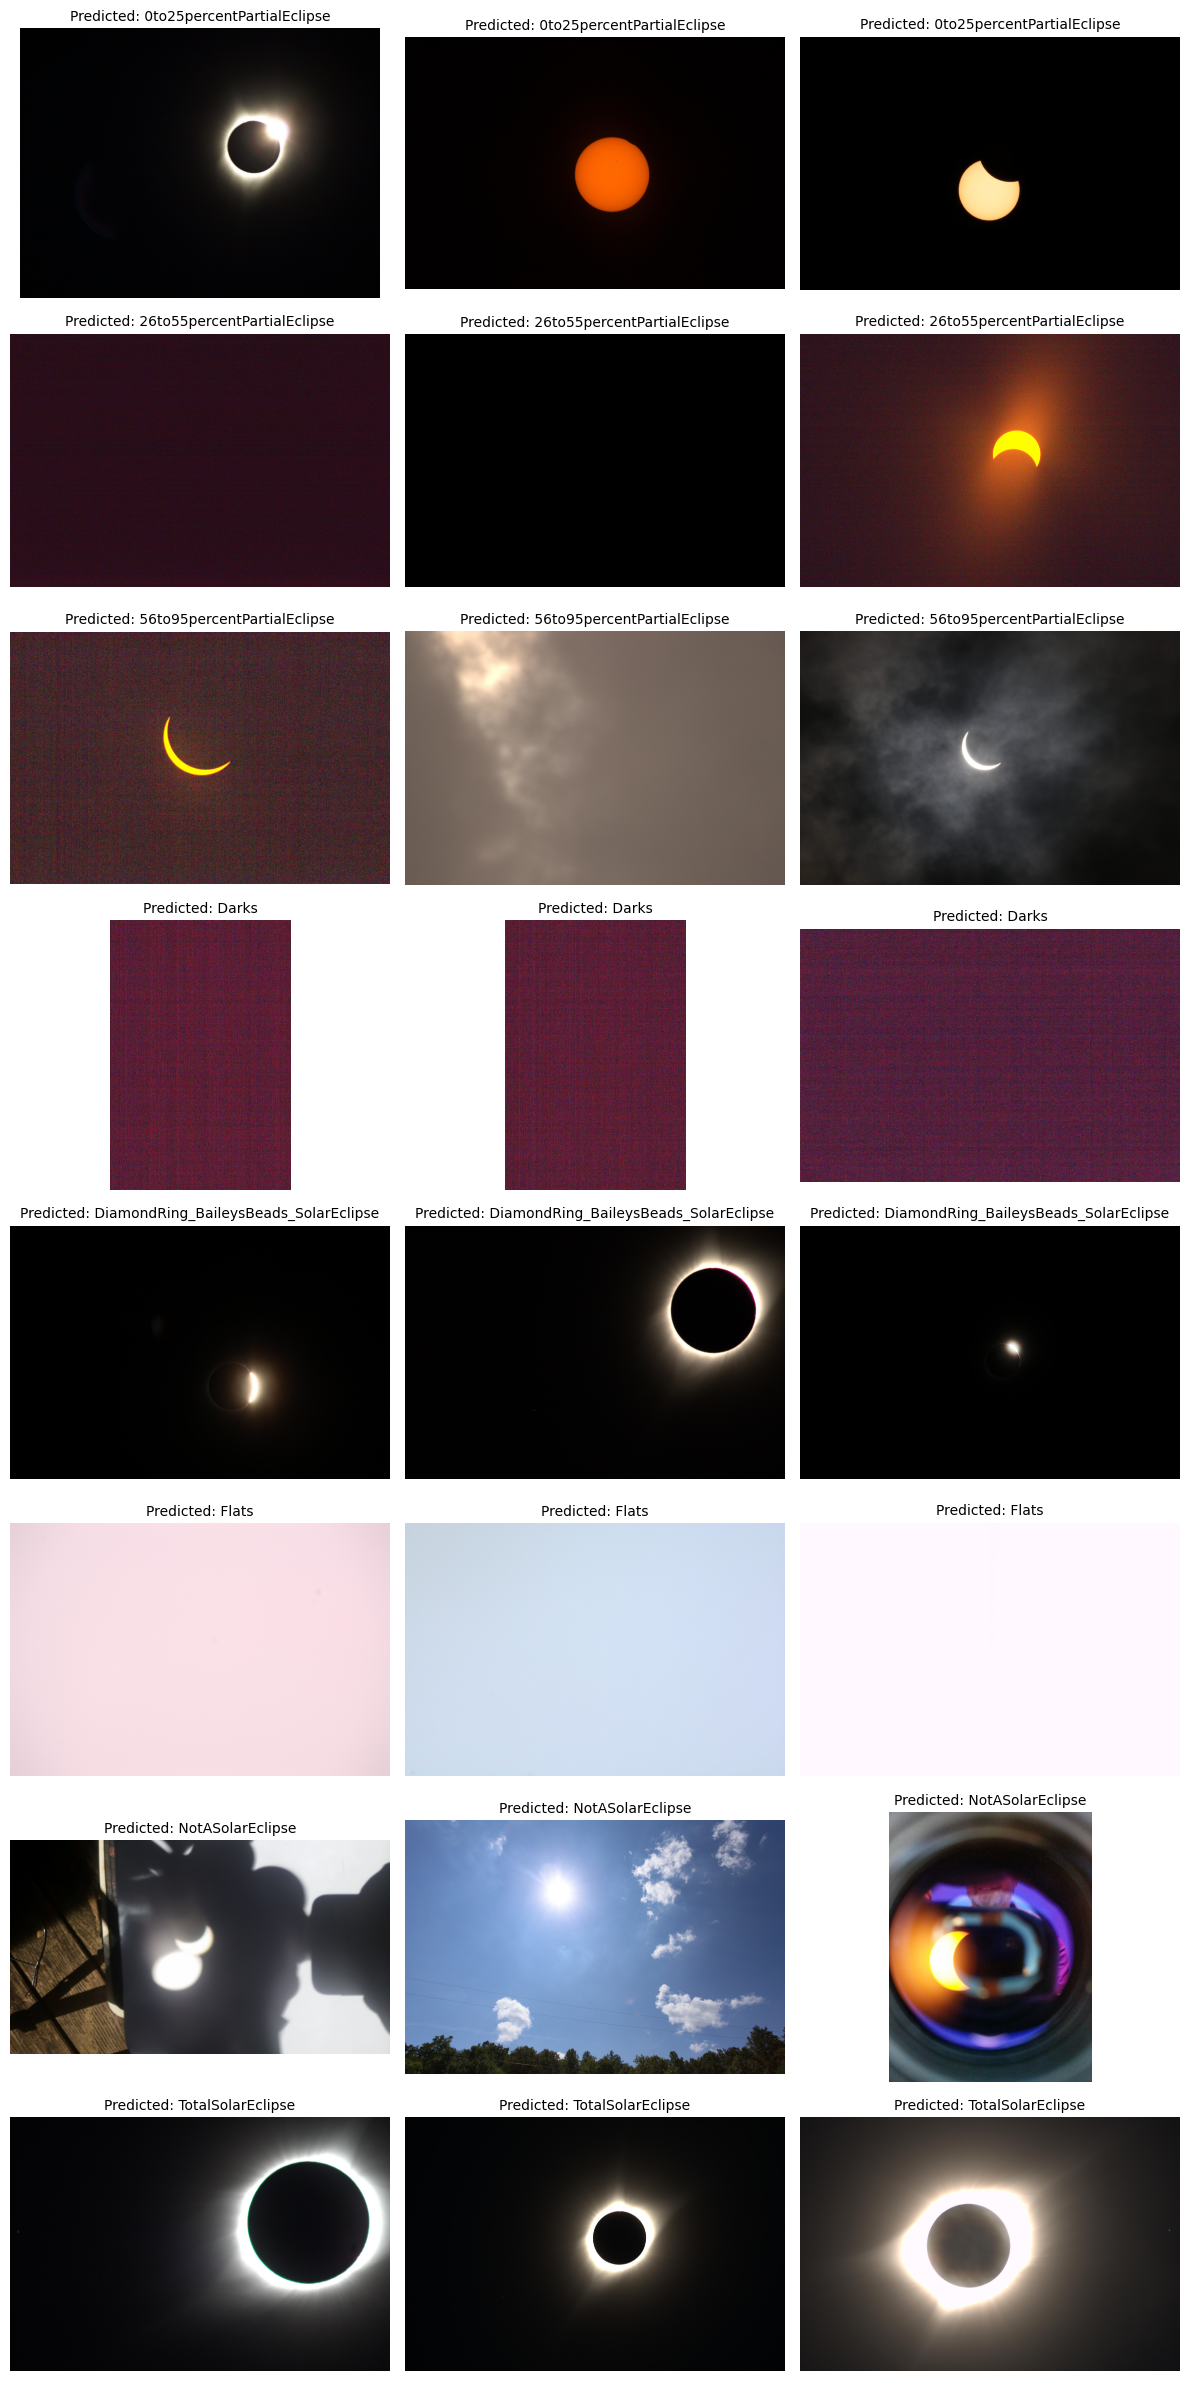

In [14]:
# Define the grid size based on the number of categories and images per category
rows = len(unique_categories)
cols = images_per_category

# Create a figure (adjust figure size based on the number of categories and images)
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))

# Loop through each predicted category and display 3 images per category
for i, category in enumerate(unique_categories):
    # Get the indices of images that belong to the current predicted category
    category_indices = [index for index, phase in enumerate(predicted_phases) if phase == category]
    
    # Randomly select 3 images from the category (or fewer if not enough images)
    num_images_to_select = min(images_per_category, len(category_indices))
    selected_indices = np.random.choice(category_indices, num_images_to_select, replace=False)
    
    # Loop through the selected images
    for j, random_index in enumerate(selected_indices):
        # Get the corresponding axes
        ax = axes[i, j]
        
        # Load the image from the test directory
        img_path = os.path.join(test_dir, test_image_filenames[random_index])
        img = plt.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        
        # Set the title as the predicted phase name
        ax.set_title(f"Predicted: {category}", fontsize=10)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



### Observations

Looking at the random samples per category, the model seems to do a good job!

In [15]:
# Create a submission file
submission = pd.DataFrame({
    'image_id': test_df['image_id'],
    'label': predicted_classes
})

print(submission)

                                              image_id  label
0    0199ec9a188382e6c0071165c0db0cc424c8567484ff6b...      1
1    f829b8f3b8be48234d43676785c5ea3edce564b790af01...      6
2    00a1d06eee5251d8d8634321560be163404e83682ec443...      0
3    0226178279c84a3f5450d2f49b58bd404a6c685b25e377...      1
4    00d2ccc4963c0f8ffb3f1c2f286b691a62043d8e01d07c...      2
..                                                 ...    ...
135  00b0ca26ff27588daae4c215fa3c63c750a821eb39637a...      5
136  00061bd3ad3000065183d936ede2ce69f17735e14a7907...      2
137  405f47f932ae4353057d72ca3f86b2cdb542b2efeb6153...      1
138  5df5b822f41ed1f67824658e78b174f111927d74242497...      1
139  002310457b9688d41b87c1523dfb31ee3fb7b6953ec797...      2

[140 rows x 2 columns]


In [16]:
# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file with numeric labels created successfully.")

Submission file with numeric labels created successfully.


## Step 5. Conclusion

This project aimed to classify images of solar eclipses into different phases using a deep learning approach. The goal was to develop a model capable of accurately identifying the phase of an eclipse from a diverse set of images.


**What Helped Improve Performance:**

To improve performance, we implemented several strategies that had a positive impact. Using MobileNetV2 as a pre-trained model provided a solid foundation, significantly enhancing the model's ability to learn from the small dataset of 495 images. Upscaling images to 224x224 allowed for better detail capture, which was crucial due to the heterogeneous nature of the image sizes and resolutions. This, combined with a lower learning rate of 0.0005 and the right balance of dropout layers (set at 0.4), helped reduce overfitting and improved generalization. Furthermore, the combination of 7 epochs and a batch size of 16 allowed the model to converge without excessively overfitting, as seen in the smoother decrease in training loss. Despite these improvements, the training accuracy stabilized at a commendable 85-90%, showing the model was learning the training data well.


**What did not help**

On the other hand, some strategies did not help as expected. Attempts to adjust the class imbalance by adding class weights to compensate for the overrepresented TotalSolarEclipse phase worsened the model’s performance. This imbalance likely contributed to the model's volatility in validation accuracy, as it tended to overfit to dominant classes while struggling with minority ones like NotASolarEclipse, which encompassed a wide variety of unstructured images.  


**Learnings and Takeaways**

Key takeaways from this project are centered around the challenges posed by small, imbalanced datasets. While pre-trained models like MobileNetV2 can significantly boost learning when training data is scarce, issues like overfitting and validation fluctuations are hard to avoid, especially with imbalanced data. We learned that data augmentation or synthetic data generation may be essential in future iterations to help balance the dataset. Additionally, more refined techniques like early stopping or cross-validation could further stabilize the validation performance. Lastly, this project highlighted the importance of careful hyperparameter tuning—from learning rates to dropout rates—in maintaining a balance between training speed, overfitting, and generalization performance.